In [176]:
import pandas as pd
import xgboost as xgb
import  matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import seaborn as sns
from numpy import absolute
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [177]:
df = pd.read_csv('../Datasets/finalized/features_missing_filledmean.csv')
crime = pd.read_csv('../Datasets/finalized/label_crime_allmetrics.csv')
cross_join = pd.merge(df, crime, on=['NeighbourhoodCode', 'Year', 'Month'])

In [178]:
cross_join['NeighbourhoodCode'] = cross_join['NeighbourhoodCode'].astype(str)
cross_join['NeighbourhoodCode'] = LabelEncoder().fit_transform(cross_join['NeighbourhoodCode']) 

<AxesSubplot:>

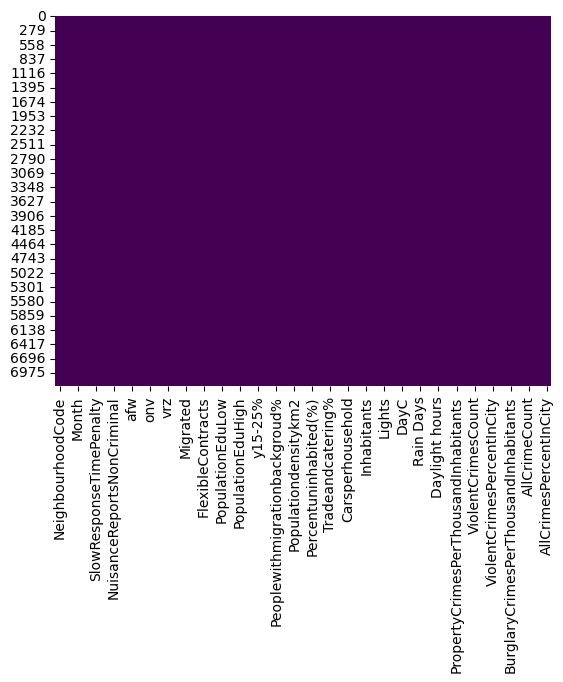

In [179]:
sns.heatmap(cross_join.isnull(), cbar=False, cmap='viridis')

In [180]:
selected = ['ResponseTimeScore',
       'SlowResponseTimePenalty', 'NuisanceReportsCriminal',
       'NuisanceReportsNonCriminal', 'lbm', 'afw', 'fys', 'onv', 'soc', 'vrz',
       'won', 'Migrated', 'NetLaborParticipation', 'FlexibleContracts',
       'SelfContract', 'PopulationEduLow', 'PopulationEduMedium',
       'PopulationEduHigh', 'y0-15%', 'y15-25%', 'y65-%',
       'Peoplewithmigrationbackgroud%', 'Averagepeopleperhousehold',
       'Populationdensitykm2', 'AverageWOZ-valueofhouses(x1000euro)',
       'Percentuninhabited(%)', 'Rentalproperies(%)', 'Tradeandcatering%',
       'Culture/recreationproperies%', 'Carsperhousehold', 'UrbanityLevel',
       'Inhabitants', 'Benches', 'Lights', 'POI', 'DayC', 'NightC',
       'Rain Days', 'Rainfall(mm)', 'Daylight hours']

X = cross_join[selected]

target = ['PropertyCrimesPerThousandInhabitants', 'ViolentCrimesPerThousandInhabitants',
          'BurglaryCrimesPerThousandInhabitants']

y = cross_join[target]

In [181]:
if False:
    # Instantiating the XGBoost regressor
    model = xgb.XGBRegressor(n_estimators=350, max_depth=60, learning_rate=0.3, subsample=1, colsample_bytree=1, random_state=1)

    cv = RepeatedKFold(n_splits=40, n_repeats=10, random_state=7)
    #cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=2)

    mae_scores = []
    for column in target:
        # Get the index of the current target column
        target_index = target.index(column)
        
        # Extract the current target column
        y_current = y.iloc[:, target_index]
        
        # Calculate the MAE for the current target column
        scores = -1 * cross_val_score(model, X, y_current, scoring='neg_mean_absolute_error', cv=cv, n_jobs=14)
        mae_scores.append(scores)

    # Print the MAE for each target column
    for i, column in enumerate(target):
        print(f"MAE for {column}: {mae_scores[i].mean():.3f} ({mae_scores[i].std():.3f})")

In [182]:
model = xgb.XGBRegressor()
model.load_model('../FinalDeliverable/app_data/artifacts/model_xgb.sav')

In [183]:
model.fit(X, y)

# Make predictions using the best model
predictions = model.predict(X)

In [184]:
predictions = predictions.flatten()
actual = y.values.flatten()

In [185]:
predictions = [max(0, pred) for pred in predictions]

In [186]:
results = pd.DataFrame({'Predicted': predictions, 'Actual': actual})

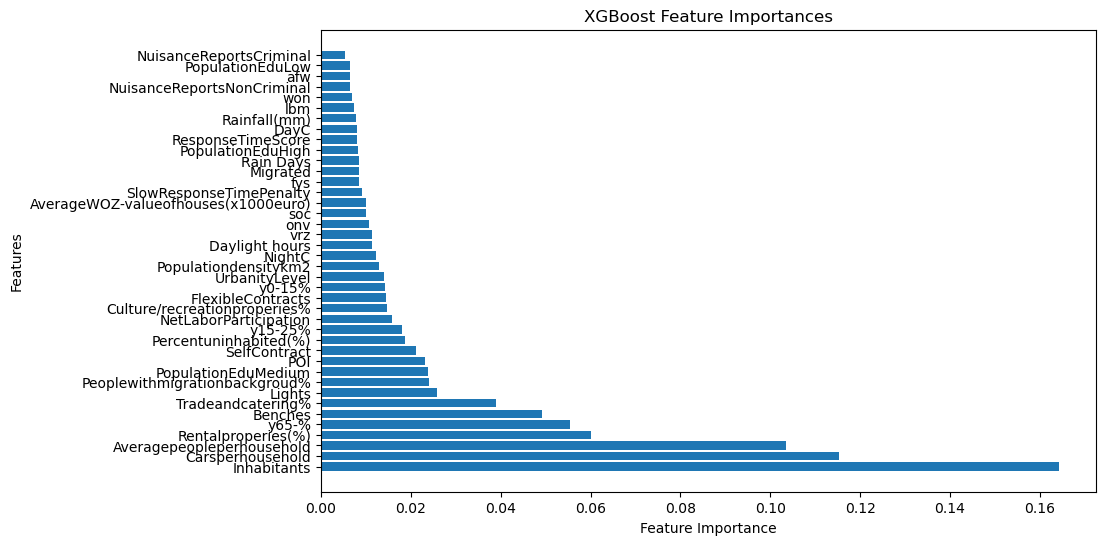

In [187]:
importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = [selected[i] for i in sorted_indices]

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importances')
plt.show()

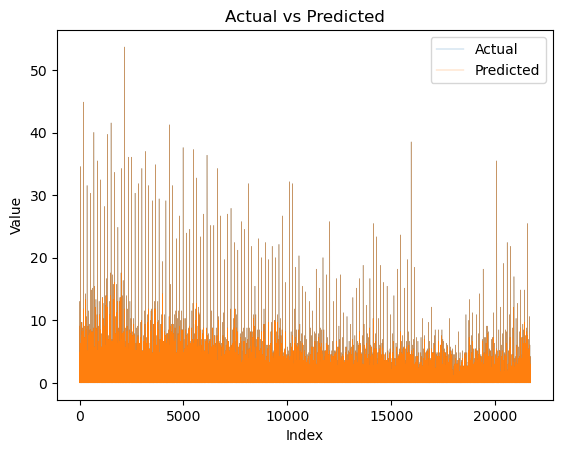

In [188]:
plt.plot(actual, label='Actual', linewidth=0.2)
plt.plot(predictions, label='Predicted', linewidth=0.2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

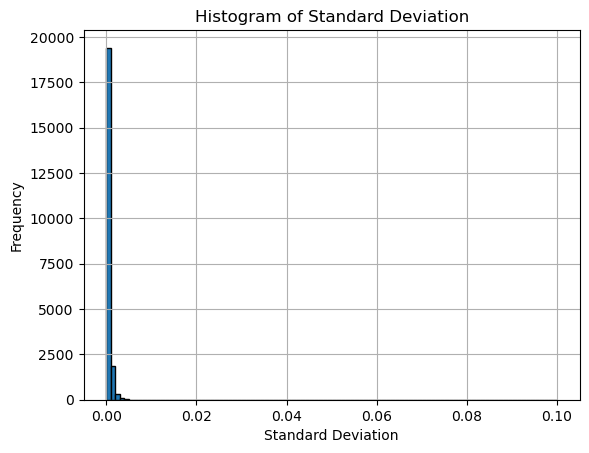

In [189]:
import numpy as np
differences = np.abs(predictions - actual)
std_deviation = np.std(differences)
num_bins = 100

plt.hist(differences, bins=num_bins, edgecolor='black', range=(0, .1))
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Deviation')
plt.grid(True)
plt.show()

In [190]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(actual, predictions)
print('Mean Squared Error (MSE):', mse)

r2 = r2_score(actual, predictions)
print('R-squared (R2):', r2)

mae = mean_absolute_error(actual, predictions)
print('Mean Absolute Error (MAE):', mae)

Mean Squared Error (MSE): 4.884701791173597e-07
R-squared (R2): 0.9999999254564542
Mean Absolute Error (MAE): 0.0004303129194776527


In [191]:
results.head(25)

,Predicted,Actual
0,9.096296,9.0973
1,1.212376,1.2130
2,1.515129,1.5162
3,5.155335,5.1551
4,0.000630,0.0000
5,0.607321,0.6065
6,4.851455,4.8519
7,0.000000,0.0000
8,0.606183,0.6065
9,3.335531,3.3357


In [192]:
%store X
%store y
%store model

Stored 'X' (DataFrame)
Stored 'y' (DataFrame)
Stored 'model' (XGBRegressor)


In [193]:
#model.save_model('../FinalDeliverable/app_data/artifacts/model_xgb.sav')

In [194]:
X.min()

ResponseTimeScore                      0.0
SlowResponseTimePenalty                0.0
NuisanceReportsCriminal                0.0
NuisanceReportsNonCriminal             0.0
lbm                                    0.0
afw                                    0.0
fys                                    0.0
onv                                    0.0
soc                                    0.0
vrz                                    0.0
won                                    0.0
Migrated                               0.0
NetLaborParticipation                  0.0
FlexibleContracts                      0.0
SelfContract                           0.0
PopulationEduLow                       0.0
PopulationEduMedium                    0.0
PopulationEduHigh                      0.0
y0-15%                                 0.0
y15-25%                                0.0
y65-%                                  0.0
Peoplewithmigrationbackgroud%          0.0
Averagepeopleperhousehold              0.0
Populationd